# Test JulES

### Import packages

In [1]:
using Pkg;
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables
#plotlyjs(); uncomment for interactive plots

In [3]:
config = YAML.load_file(joinpath(dirname(dirname(pwd())), "JulESIO", "config_jules_solbatteri.yml"))
scenarioyear = 1991
datayear = 2024

2024

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 1


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

In [7]:
function getdataset(config, scenarioyear)
    settings = config[config["main"]["settings"]]
    
    elements = DataElement[]

    # Solar, battery and transmission parameters
    transmcap = config["data"]["transmcap"] # MW
    transmeff = config["data"]["transmeff"] # Small loss to avoid unnecessary transfers
    storagecap = config["data"]["storagecap"] # GWh
    chargecap = config["data"]["chargecap"]# MW
    lossbattery = config["data"]["lossbattery"] # the whole loss when the battery charges
    solarcap = config["data"]["solarcap"] # MW

    # Power balances for price areas and transmission
    addexogenbalance!(elements, "PowerBalance_ExternalHub", "Power", "AreaPrice")
    price_path = joinpath(config["main"]["input"], config["data"]["price"])
    df = CSV.read(price_path, DataFrame; header=3, decimal=',', types=Float64)
    df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
    df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
    df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => df[:,"Vestsyd"].*1000))) # *1000 to go from €/MWh to €/GWh
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")

    addbalance!(elements, "PowerBalance_HomeHub", "Power")

    addpowertrans!(elements, "PowerBalance_ExternalHub", "PowerBalance_HomeHub", transmcap, transmeff)
    addpowertrans!(elements, "PowerBalance_HomeHub", "PowerBalance_ExternalHub", transmcap, transmeff)

    # Add battery
    addbattery!(elements, "Battery", "PowerBalance_HomeHub", storagecap, lossbattery, chargecap)

    # Add solar production as an RHSTerm
    solar_path = joinpath(config["main"]["input"], config["data"]["solar"]) # profiles from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
    df = CSV.read(solar_path, DataFrame)
    dfmt = DateFormat("yyyy-mm-dd HH:MM:SS")
    df.Timestamp = DateTime.(df.Timestamp, dfmt)
    @assert issorted(df.Timestamp)
    start = first(df.Timestamp)
    numperiods = length(df.Timestamp)
    push!(elements, DataElement(TIMEINDEX_CONCEPT, "RangeTimeIndex", "SolProfileTimeIndex", 
            Dict("Start" => start, "Delta" => Hour(1), "Steps" => numperiods)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT, "VectorTimeValues", "SolProfilValues",
            Dict("Vector" => df.SolarGER)))
    push!(elements, DataElement(TIMEVECTOR_CONCEPT, "RotatingTimeVector", "SolProfil",
            Dict(TIMEVALUES_CONCEPT => "SolProfilValues", TIMEINDEX_CONCEPT => "SolProfileTimeIndex")))
    push!(elements, DataElement(PARAM_CONCEPT, "MWToGWhSeriesParam", "SolParam", Dict("Level" => solarcap, "Profile" => "SolProfil")))
    addrhsterm!(elements, "SolParam", "PowerBalance_HomeHub", DIRECTIONIN)

    return Dict("elements" => elements, "detailedrescopl" => Dict())
end


getdataset (generic function with 1 method)

In [8]:
dataset = getdataset(config, scenarioyear)

Dict{String, Any} with 2 entries:
  "elements"        => DataElement[DataElement("Balance", "ExogenBalance", "Pow…
  "detailedrescopl" => Dict{Any, Any}()

In [9]:
data = JulES.run_serial(config, datayear, scenarioyear, dataset)

Time parameters
  0.029110 seconds (1.28 k allocations: 83.767 KiB, 99.30% compilation time)
Get data
  0.000030 seconds (9 allocations: 656 bytes)
Make dummy objects


  0.491960 seconds (126.00 k allocations: 8.325 MiB, 97.44% compilation time)
Init scenario modelling for simulation, prognosis and stochastic
  0.000053 seconds
Init stochastic


  0.253940 seconds (183.41 k allocations: 12.284 MiB, 97.94% compilation time)


  6.077709 seconds (2.52 M allocations: 166.988 MiB, 1.67% gc time, 98.46% compilation time: <1% of which was recompilation)


  0.079406 seconds (46.33 k allocations: 3.151 MiB, 99.71% compilation time)


  9.935486 seconds (3.89 M allocations: 257.104 MiB, 1.58% gc time, 98.79% compilation time: <1% of which was recompilation)
Init results


  1.507651 seconds (556.02 k allocations: 38.122 MiB, 3.21% gc time, 99.10% compilation time)


Simulate forward
FixedDataTwoTime(

DateTime("2024-01-01T00:00:00"), DateTime("1991-01-02T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-04T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-06T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-08T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-10T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-12T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-14T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-16T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-18T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-20T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-22T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-24T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-26T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-28T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-01-30T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-01T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-03T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-05T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-07T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-09T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-11T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-13T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-15T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-17T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-19T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-21T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-23T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-25T00:00:00")

)
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-02-27T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-01T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-03T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-05T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-07T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-09T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-11T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-13T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-15T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime

("1991-03-17T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-19T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-21T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-23T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-25T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-27T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-29T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-03-31T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-02T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-04T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-06T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-08T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-10T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-12T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-14T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-16T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-18T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-20T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-22T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-24T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-26T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-28T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-04-30T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-02T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-04T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-06T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-08T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-10T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-12T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-14T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-16T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-18T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-20T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-22T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-24T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-26T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-28T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-05-30T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-01T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-03T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-05T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-07T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-09T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-11T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-13T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-15T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-17T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-19T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-21T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-23T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-25T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-27T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-06-29T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-01T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-03T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-05T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-07T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-09T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-11T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-13T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-15T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-17T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-19T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-21T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-23T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-25T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-27T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-29T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-07-31T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-02T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-04T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-06T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-08T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), 

DateTime("1991-08-10T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-12T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-14T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-16T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-18T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-20T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-22T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-24T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-26T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-28T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-08-30T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-01T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-03T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-05T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-07T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-09T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-11T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-13T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-15T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-17T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-19T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-21T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-23T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-25T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-27T00:00:00")

)
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-09-29T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-01T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-03T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-05T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-07T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-09T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-11T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-13T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-15T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-17T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-19T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-21T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-23T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-25T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-27T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-29T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-10-31T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-02T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-04T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-06T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), 

DateTime("1991-11-08T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-10T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-12T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-14T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-16T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-18T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-20T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-22T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-24T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-26T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-28T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-11-30T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-02T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-04T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-06T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime

("1991-12-08T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-10T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-12T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-14T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-16T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-18T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-20T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-22T00:00:00"))


FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-24T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-26T00:00:00"))
FixedDataTwoTime(DateTime("2024-01-01T00:00:00"), DateTime("1991-12-28T00:00:00"))
The simulation took: 0.17770452499999997 minutes


Time usage per timestep: 0.05858390934065934 seconds
Handle output


1×11 DataFrame
 Row │ umaster      usub       conv       count    smaster     ssub       hlma ⋯
     │ Float64      Float64    Float64    Float64  Float64     Float64    Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.000283165  0.0112578  0.0307149  2.20442  0.00292883  0.0269424  5.37 ⋯
                                                               5 columns omitted

1×10 DataFrame
 Row │ core   umaster_sum  usub_sum   conv_sum   count_sum  smaster_sum  ssub_ ⋯
     │ Int64  Float64      Float64    Float64    Float64    Float64      Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1  0.000283165  0.0112578  0.0307149    2.20442   0.00292883  0.026 ⋯
                                                               4 columns omitted

9-element Vector{Float64}:
 0.0002831651933701658
 0.011257798895027624
 0.030714867403314916
 2.2044198895027622
 0.0029288309392265194
 0.026942363535911604
 5.374033149171271e-6
 1.90292817679558e-5
 0.04255807679558011

 11.704438 seconds (9.43 M allocations: 606.727 MiB, 3.14% gc time, 99.51% compilation time: 7% of which was recompilation)


Dict{Any, Any} with 25 entries:
  "svindex"            => [DateTime("1990-12-31T00:00:00"), DateTime("1991-01-0…
  "demandbalancenames" => SubString{String}["HomeHub", "HomeHub", "ExternalHub"…
  "skipfactor"         => 1.0
  "stochastictimes"    => [0.0002564 0.0141008 … 3.12e-5 0.0578498; 0.0002348 0…
  "resindex"           => [DateTime("1990-12-31T00:00:00"), DateTime("1990-12-3…
  "areanames"          => ["HomeHub", "ExternalHub"]
  "priceindex"         => [DateTime("1990-12-31T00:00:00"), DateTime("1990-12-3…
  "batmatrix"          => [0.005; -0.0; … ; -0.0; 0.0;;]
  "stateindex"         => [DateTime("1990-12-31T00:00:00"), DateTime("1991-01-0…
  "statematrix"        => [0.01 -0.0; 0.01 0.01; … ; 0.01 0.0; 0.01 0.0]
  "statenames"         => ["BatteryStorage_Battery_max", "BatteryStorage_Batter…
  "resnames"           => String[]
  "shorts"             => Bool[1]
  "demandvalues"       => [-0.0 0.0 0.0 0.0; 0.005 0.0 0.0 0.0; … ; 0.0 0.0 0.0…
  "batindex"           => [DateTime("1

In [10]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = permutedims(data["statematrix"])
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"]

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"];

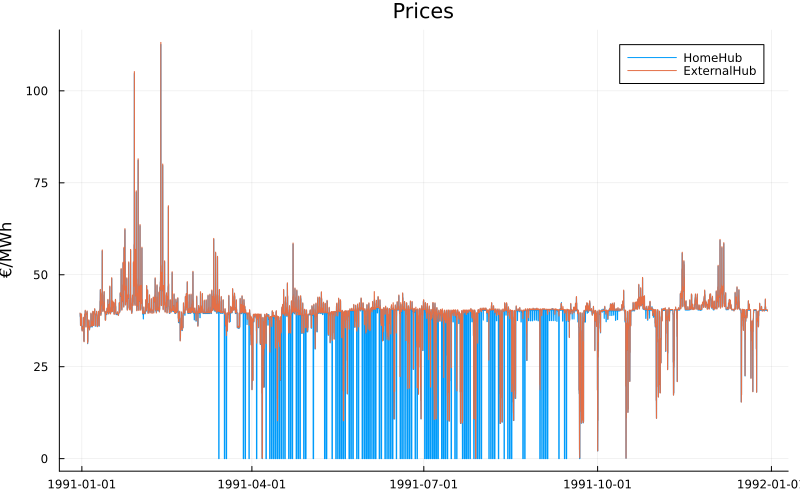

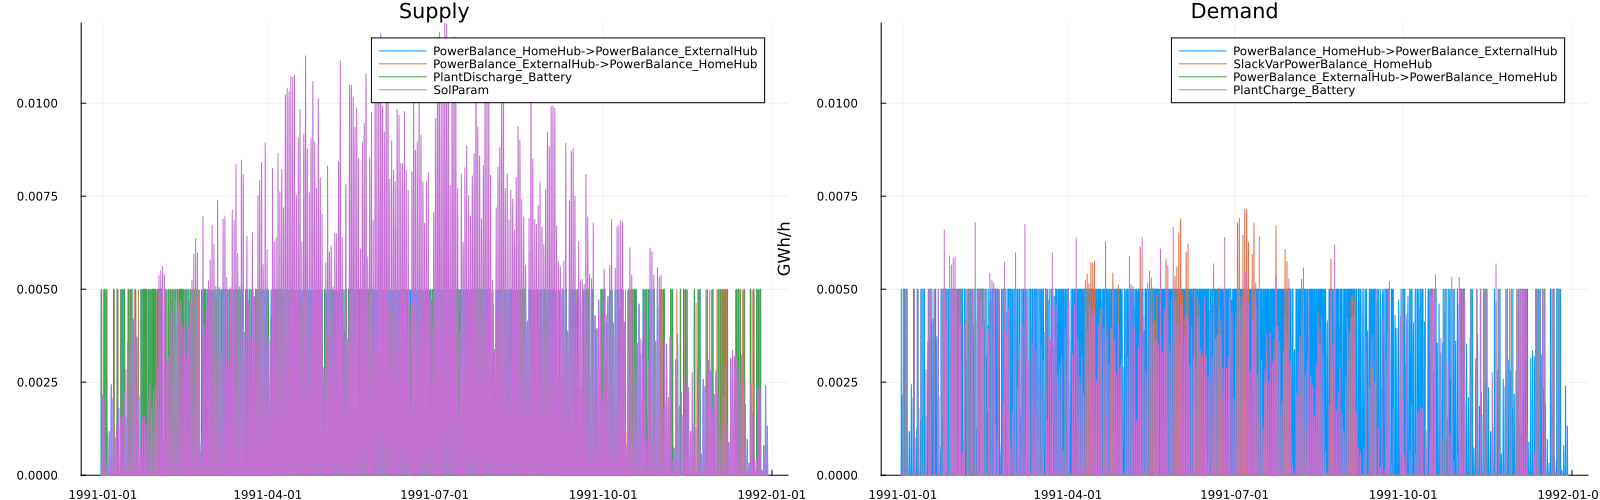

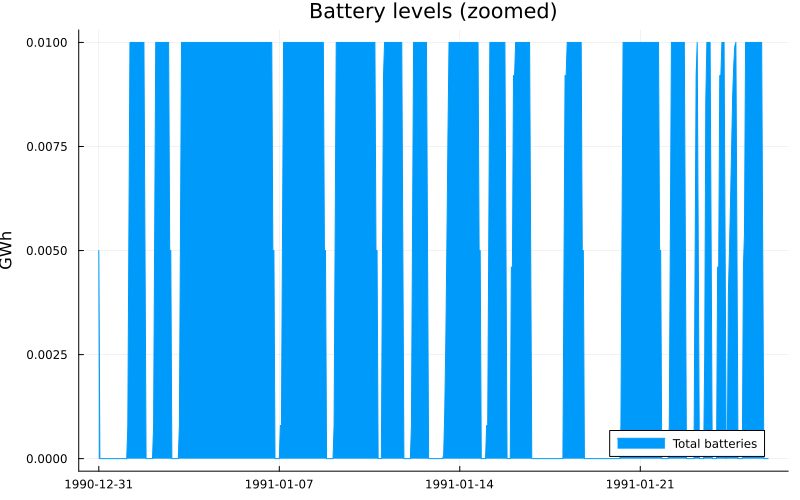

┌────────────────────────────────────────────────┬───────────────────┬────────────────────────────────────────────────┬───────────────────┐
│                                     Supplyname │ Yearly_supply_TWh │                                     Demandname │ Yearly_demand_TWh │
├────────────────────────────────────────────────┼───────────────────┼────────────────────────────────────────────────┼───────────────────┤
│                                       SolParam │         0.0153909 │ PowerBalance_HomeHub->PowerBalance_ExternalHub │          0.014681 │
│ PowerBalance_HomeHub->PowerBalance_ExternalHub │         0.0146076 │                            PlantCharge_Battery │        0.00316354 │
│                         PlantDischarge_Battery │        0.00293129 │                   SlackVarPowerBalance_HomeHub │        0.00133202 │
│ PowerBalance_ExternalHub->PowerBalance_HomeHub │       0.000854328 │ PowerBalance_ExternalHub->PowerBalance_HomeHub │       0.000858621 │
└───────────────────

┌───────────────────────────────────┬───────────────────────────────────┐
│ Yearly_supply_TWh_sum_skipmissing │ Yearly_demand_TWh_sum_skipmissing │
├───────────────────────────────────┼───────────────────────────────────┤
│                         0.0337841 │                         0.0200351 │
└───────────────────────────────────┴───────────────────────────────────┘


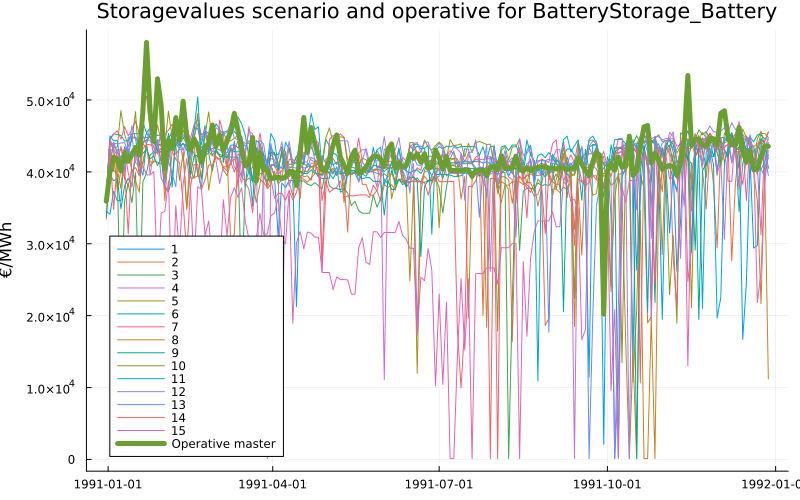

┌────────────────────────────────────────────────┬──────────────────┬────────────────────────────────────────────────┬───────────────────┐
│                                     Supplyname │ Yearly_rev_mill€ │                                     Demandname │ Yearly_cost_mill€ │
├────────────────────────────────────────────────┼──────────────────┼────────────────────────────────────────────────┼───────────────────┤
│ PowerBalance_HomeHub->PowerBalance_ExternalHub │          566.064 │ PowerBalance_HomeHub->PowerBalance_ExternalHub │           411.834 │
│                                       SolParam │          321.339 │                            PlantCharge_Battery │           67.4339 │
│                         PlantDischarge_Battery │          128.569 │ PowerBalance_ExternalHub->PowerBalance_HomeHub │           29.3602 │
│ PowerBalance_ExternalHub->PowerBalance_HomeHub │          29.3602 │                   SlackVarPowerBalance_HomeHub │               0.0 │
└──────────────────────────

In [11]:
# Plot prices
display(plot(x1, prices/1000, labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
display(plot([supplychart,demandchart]...,layout=(1,2),size=(1600,500)))

# Plot storages
display(areaplot(x1[1:624], dropdims(sum(batterylevels,dims=2),dims=2)[1:624],labels="Total batteries",size=(800,500),title="Battery levels (zoomed)", ylabel = "GWh", fmt = :html))

# Plot list of yearly mean production and demand for each supply/demand
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader=false)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader=false)

# Plot list of yearly income and cost for each supply/demand
supplyrev = copy(supplyvalues)
for (i,supplybalancename) in enumerate(supplybalancenames)
    idx = findfirst(isequal(supplybalancename), powerbalancenames)
    supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
end
demandrev = copy(demandvalues)
for (i,demandbalancename) in enumerate(demandbalancenames)
    idx = findfirst(isequal(demandbalancename), powerbalancenames)
    demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
end
meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
supplyrevdf[!,:ID] = collect(1:length(supplynames))
demandrevdf[!,:ID] = collect(1:length(demandnames))
joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
pretty_table(joinedrevdf, show_subheader=false)

# Sum revenues and cost
pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader=false)

# Plot storagevalues for each reservoir and scenarios
numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
numscen = length(scenarionames) - numop
for (i, storagename) in enumerate(storagenames)
    p = plot(x3, storagevalues[:,1:numscen,i] / -1, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
    plot!(p, x3, storagevalues[:,numscen+1:end,i] / -1, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
    display(p)
 end